In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
local_save = "E:/coding/github/data_science_with_letras/data"
data = pd.read_csv(f'{local_save}/silver_data_lyrics.csv')
# Remover pontos, vírgulas e excessos de espaços na coluna
data['views'] = data['views'].str.replace(r'[.,;]', '').str.replace(r'\s+', ' ').str.strip()
data['views'] = data['views'].astype(int)
data['n_verses'] = data['n_verses'].astype(int)
data['n_rows'] = data['n_rows'].astype(int)

categorical_cols = ['genre']
continuous_cols = ['n_verses','n_rows', 'views']
text_col = 'clean_lyric'

df = pd.DataFrame(data, columns=categorical_cols + continuous_cols + [text_col])

C:\Users\DERPO\AppData\Local\Temp\ipykernel_19768\2934331246.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['views'] = data['views'].str.replace(r'[.,;]', '').str.replace(r'\s+', ' ').str.strip()


In [3]:
df.head(2)

,genre,n_verses,n_rows,views,clean_lyric
0,alternativo,5,19,645,so always let it be more light now youre in th...
1,alternativo,5,14,763,i dont know since when i changed to such a col...


In [5]:
# Preprocessamento de texto
stopw = set(stopwords.words('portuguese'))
#tfidf_vectorizer = TfidfVectorizer(stop_words=stopw)
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)

# Transformações para dados categóricos e contínuos
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_encoding', OneHotEncoder(), categorical_cols),
        ('numeric_scaling', StandardScaler(), continuous_cols),
        ('text_preprocessing', tfidf_vectorizer, text_col)
    ])

# Redução de dimensionalidade com TruncatedSVD
svd = TruncatedSVD(n_components=2)

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svd', svd),
    ('clustering', KMeans(n_clusters=3))
])

pipeline.fit(df)

# Obter rótulos dos clusters
labels = pipeline.named_steps['clustering'].labels_

# Adicionar rótulos aos dados originais
df['cluster_label'] = labels


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [6]:
components = pipeline.named_steps['svd'].transform(preprocessor.transform(df.drop('cluster_label', axis=1)))

In [10]:
df['pc1'] = components[:, 0]
df['pc2'] = components[:, 1]

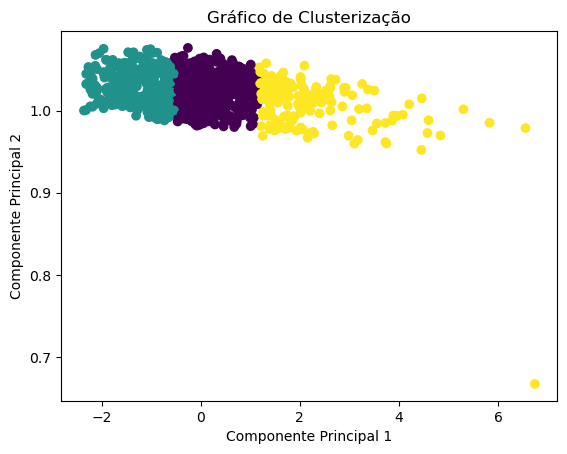

In [11]:
# Plotar gráfico com dois componentes principais
plt.scatter(components[:, 0], components[:, 1], c=labels)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de Clusterização')
plt.show()

In [16]:
df['symbol'] = data['views'].apply(lambda x: 'pouco' if x < 100 else 'médio' if x < 500 else 'grande')


In [17]:
df

,genre,n_verses,n_rows,views,clean_lyric,cluster_label,pc1,pc2,symbol
0,alternativo,5,19,645,so always let it be more light now youre in th...,1,-0.844394,1.050925,grande
1,alternativo,5,14,763,i dont know since when i changed to such a col...,1,-1.058462,1.059465,grande
2,alternativo,4,52,245,baby when i met you there was peace unknown i ...,0,0.395830,1.043669,médio
3,alternativo,7,41,345,its just a waste of time if you cant do anymor...,0,0.461461,0.992731,médio
4,alternativo,8,22,163,i came across that scenery it brought back tho...,0,-0.175243,1.003226,médio
...,...,...,...,...,...,...,...,...,...
995,alternativo,7,26,18,unh ghost town hey get in ill take you for a r...,0,-0.181045,1.017387,pouco
996,alternativo,18,50,17,go away ghosts go far away i dont want you in ...,2,2.857968,1.005041,pouco
997,alternativo,13,57,98,this song is dedicated to the girl that i love...,2,2.251038,1.018984,pouco
998,alternativo,12,41,87,they say that part of growing up is getting a ...,2,1.381597,1.039886,pouco


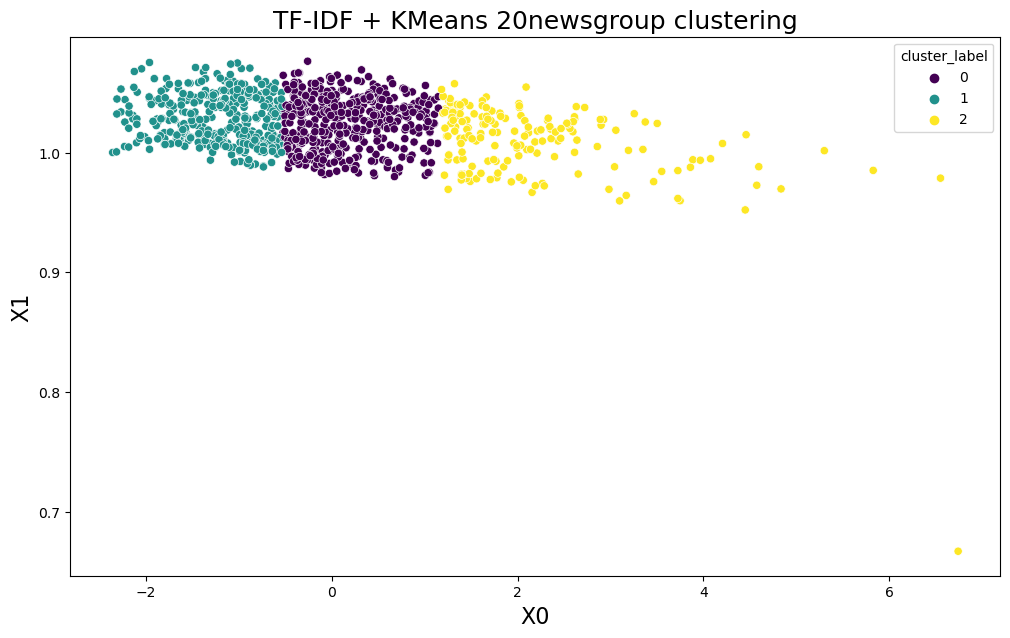

In [13]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster_label', palette="viridis")
plt.show()

In [19]:
fig = px.scatter(df, y="pc1", x="pc2", color="cluster_label", symbol="symbol")
fig.update_traces(marker_size=5)
fig.show()

In [41]:
df.to_csv(f'{local_save}/after_clustering.csv',index=False)